[Reference](https://medium.com/@buttonscodes/plotting-with-python-a-study-of-market-periodicity-a218647e2923)

In [1]:
symbol = 'IBM'
header = ['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']

In [2]:
import requests

symbol = 'IBM'
alpha_vantage_api_key = 'demo'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={alpha_vantage_api_key}'
r = requests.get(url)
data = r.json()

print(data['Time Series (Daily)']['2021-11-18'])

{'1. open': '118.36', '2. high': '118.36', '3. low': '116.31', '4. close': '116.66', '5. adjusted close': '115.244474697', '6. volume': '5047879', '7. dividend amount': '0.0000', '8. split coefficient': '1.0'}


In [3]:
import csv
from tqdm.notebook import tqdm, trange # for progress bar

with open(f'{symbol}_adjusted_daily_full.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    
    for key, jrow in tqdm(data['Time Series (Daily)'].items()):
        row = [key, jrow['1. open'], jrow['2. high'], jrow['3. low'], jrow['4. close'], 
               jrow['5. adjusted close'], jrow['6. volume'], jrow['7. dividend amount'],
               jrow['8. split coefficient']]
        writer.writerow(row)

  0%|          | 0/5663 [00:00<?, ?it/s]

In [4]:
import csv
from tqdm.notebook import tqdm, trange # for progress bar

rows = []
with open(f'{symbol}_adjusted_daily_full.csv', 'r', encoding='UTF8') as f:
    reader = csv.reader(f)
    next(reader)
    for i, row in tqdm(enumerate(reader)):
        rows.append(row)

print(rows[0])

0it [00:00, ?it/s]

['2022-05-03', '133.0', '133.6', '131.99', '132.52', '132.52', '3688574', '0.0000', '1.0']


In [5]:
import pandas as pd

by_years = []

for row in tqdm(rows):
    if len(by_years) == 0:
        by_years_cur = []
        by_years_cur.insert(0, row)
        by_years.insert(0, by_years_cur)
    else:
        row_year = pd.to_datetime(row[0], format='%Y-%m-%d').year
        by_years_cur = by_years[0]
        cur_year = pd.to_datetime(by_years_cur[0][0], format='%Y-%m-%d').year
        if row_year == cur_year:
            by_years_cur.insert(0, row)
        else:
            by_years_cur = []
            by_years_cur.insert(0, row)
            by_years.insert(0, by_years_cur)

print(header)
print(by_years[2][3])

  0%|          | 0/5663 [00:00<?, ?it/s]

['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']
['2001-01-05', '93.94', '94.69', '91.0', '94.0', '54.0525863258', '8043200', '0.0000', '1.0']


In [6]:
by_years_with_day = []
for year_rows in tqdm(by_years):
    year_rows_with_day = []
    by_years_with_day.append(year_rows_with_day)
    for row in year_rows:
        dayofyear = pd.to_datetime(row[0], format='%Y-%m-%d').dayofyear
        year_rows_with_day.append([dayofyear] + row)
        

print([f'{index}:{elmt}' for index, elmt in enumerate(['day']+header)])
print([f'{index}:{elmt}' for index, elmt in enumerate(by_years_with_day[0][4])])    

  0%|          | 0/24 [00:00<?, ?it/s]

['0:day', '1:date', '2:open', '3:high', '4:low', '5:close', '6:adjusted_close', '7:volume', '8:dividend_amount', '9:split_coefficient']
['0:309', '1:1999-11-05', '2:92.75', '3:92.94', '4:90.19', '5:90.25', '6:51.5929021189', '7:13737600', '8:0.0000', '9:1.0']


  0%|          | 0/24 [00:00<?, ?it/s]

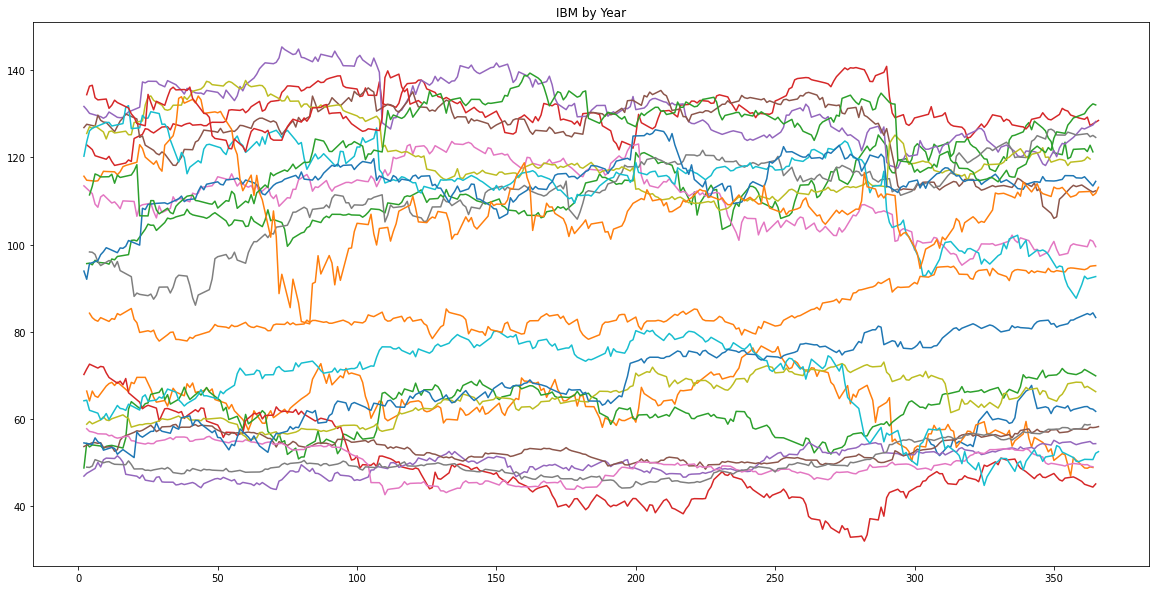

In [7]:
import numpy as np
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for year_rows in tqdm(by_years_with_day):
    np_year_rows = np.array(year_rows)[:,[0,6]].T
    plt.plot(np_year_rows[0].astype(int), np_year_rows[1].astype(float))

plt.title(f'{symbol} by Year')
plt.show()

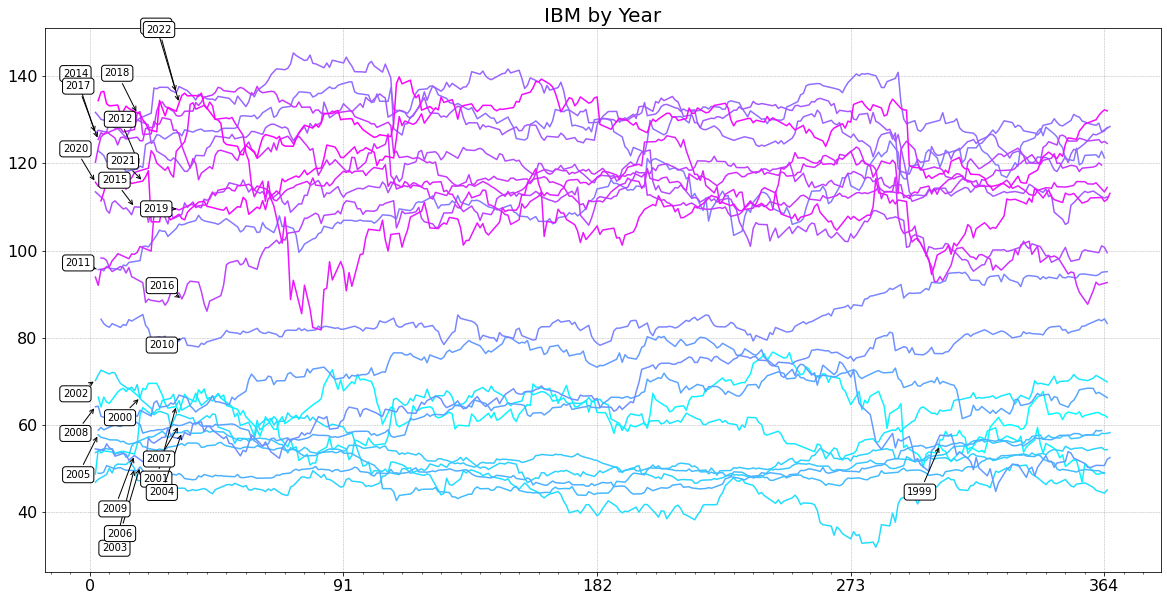

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

plt.title(f'{symbol} by Year', fontsize=20)

# create color map
color_map = cm.get_cmap('cool', len(by_years_with_day))
color_map = color_map(np.linspace(0, 1, len(by_years_with_day)))
    # color_map = np.flip(color_map, axis=0) # <-- can flip the color map like this if want to

# make the font bigger
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# set major ticks to every quarter
ax.xaxis.set_major_locator(MultipleLocator(91))
# set minor ticks to every week
ax.xaxis.set_minor_locator(MultipleLocator(7))

# add quarter vertical lines
plt.grid(True, 'major', 'x', ls='--', lw=.5, c='k', alpha=.3)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

# calculate annotation offsets to spread them out so they don't overlap so much:

annot_y_range = 160
annot_y_incr = annot_y_range / len(by_years_with_day)
annot_y_offset = -annot_y_range / 2

year_start_y = [[indx,float(elmt[0][6])] for indx, elmt in enumerate(by_years_with_day)]
#print(year_start_y)
year_start_y.sort(key=lambda x: x[1])
#print(year_start_y)
annot_y_offsets = {elmt[0]:annot_y_offset + indx*annot_y_incr for indx, elmt in enumerate(year_start_y)}
#print(annot_y_offsets)

# plot the lines:

for indx, year_rows in enumerate(by_years_with_day):
    year = pd.to_datetime(year_rows[0][1], format='%Y-%m-%d').year
    np_year_rows = np.array(year_rows)[:,[0,6]].T
    plt.plot(np_year_rows[0].astype(int), np_year_rows[1].astype(float), 
             color=color_map[indx])
    
    # annotate the lines
    ax.annotate(str(year), xy=(int(np_year_rows[0][10*(indx%3)]),float(np_year_rows[1][10*(indx%3)])), 
                    xycoords='data',
                    xytext=(-20,annot_y_offsets[indx]),
                    textcoords="offset points",
                    fontsize=10,
                    va="center",
                    ha="center",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))

    
plt.show()

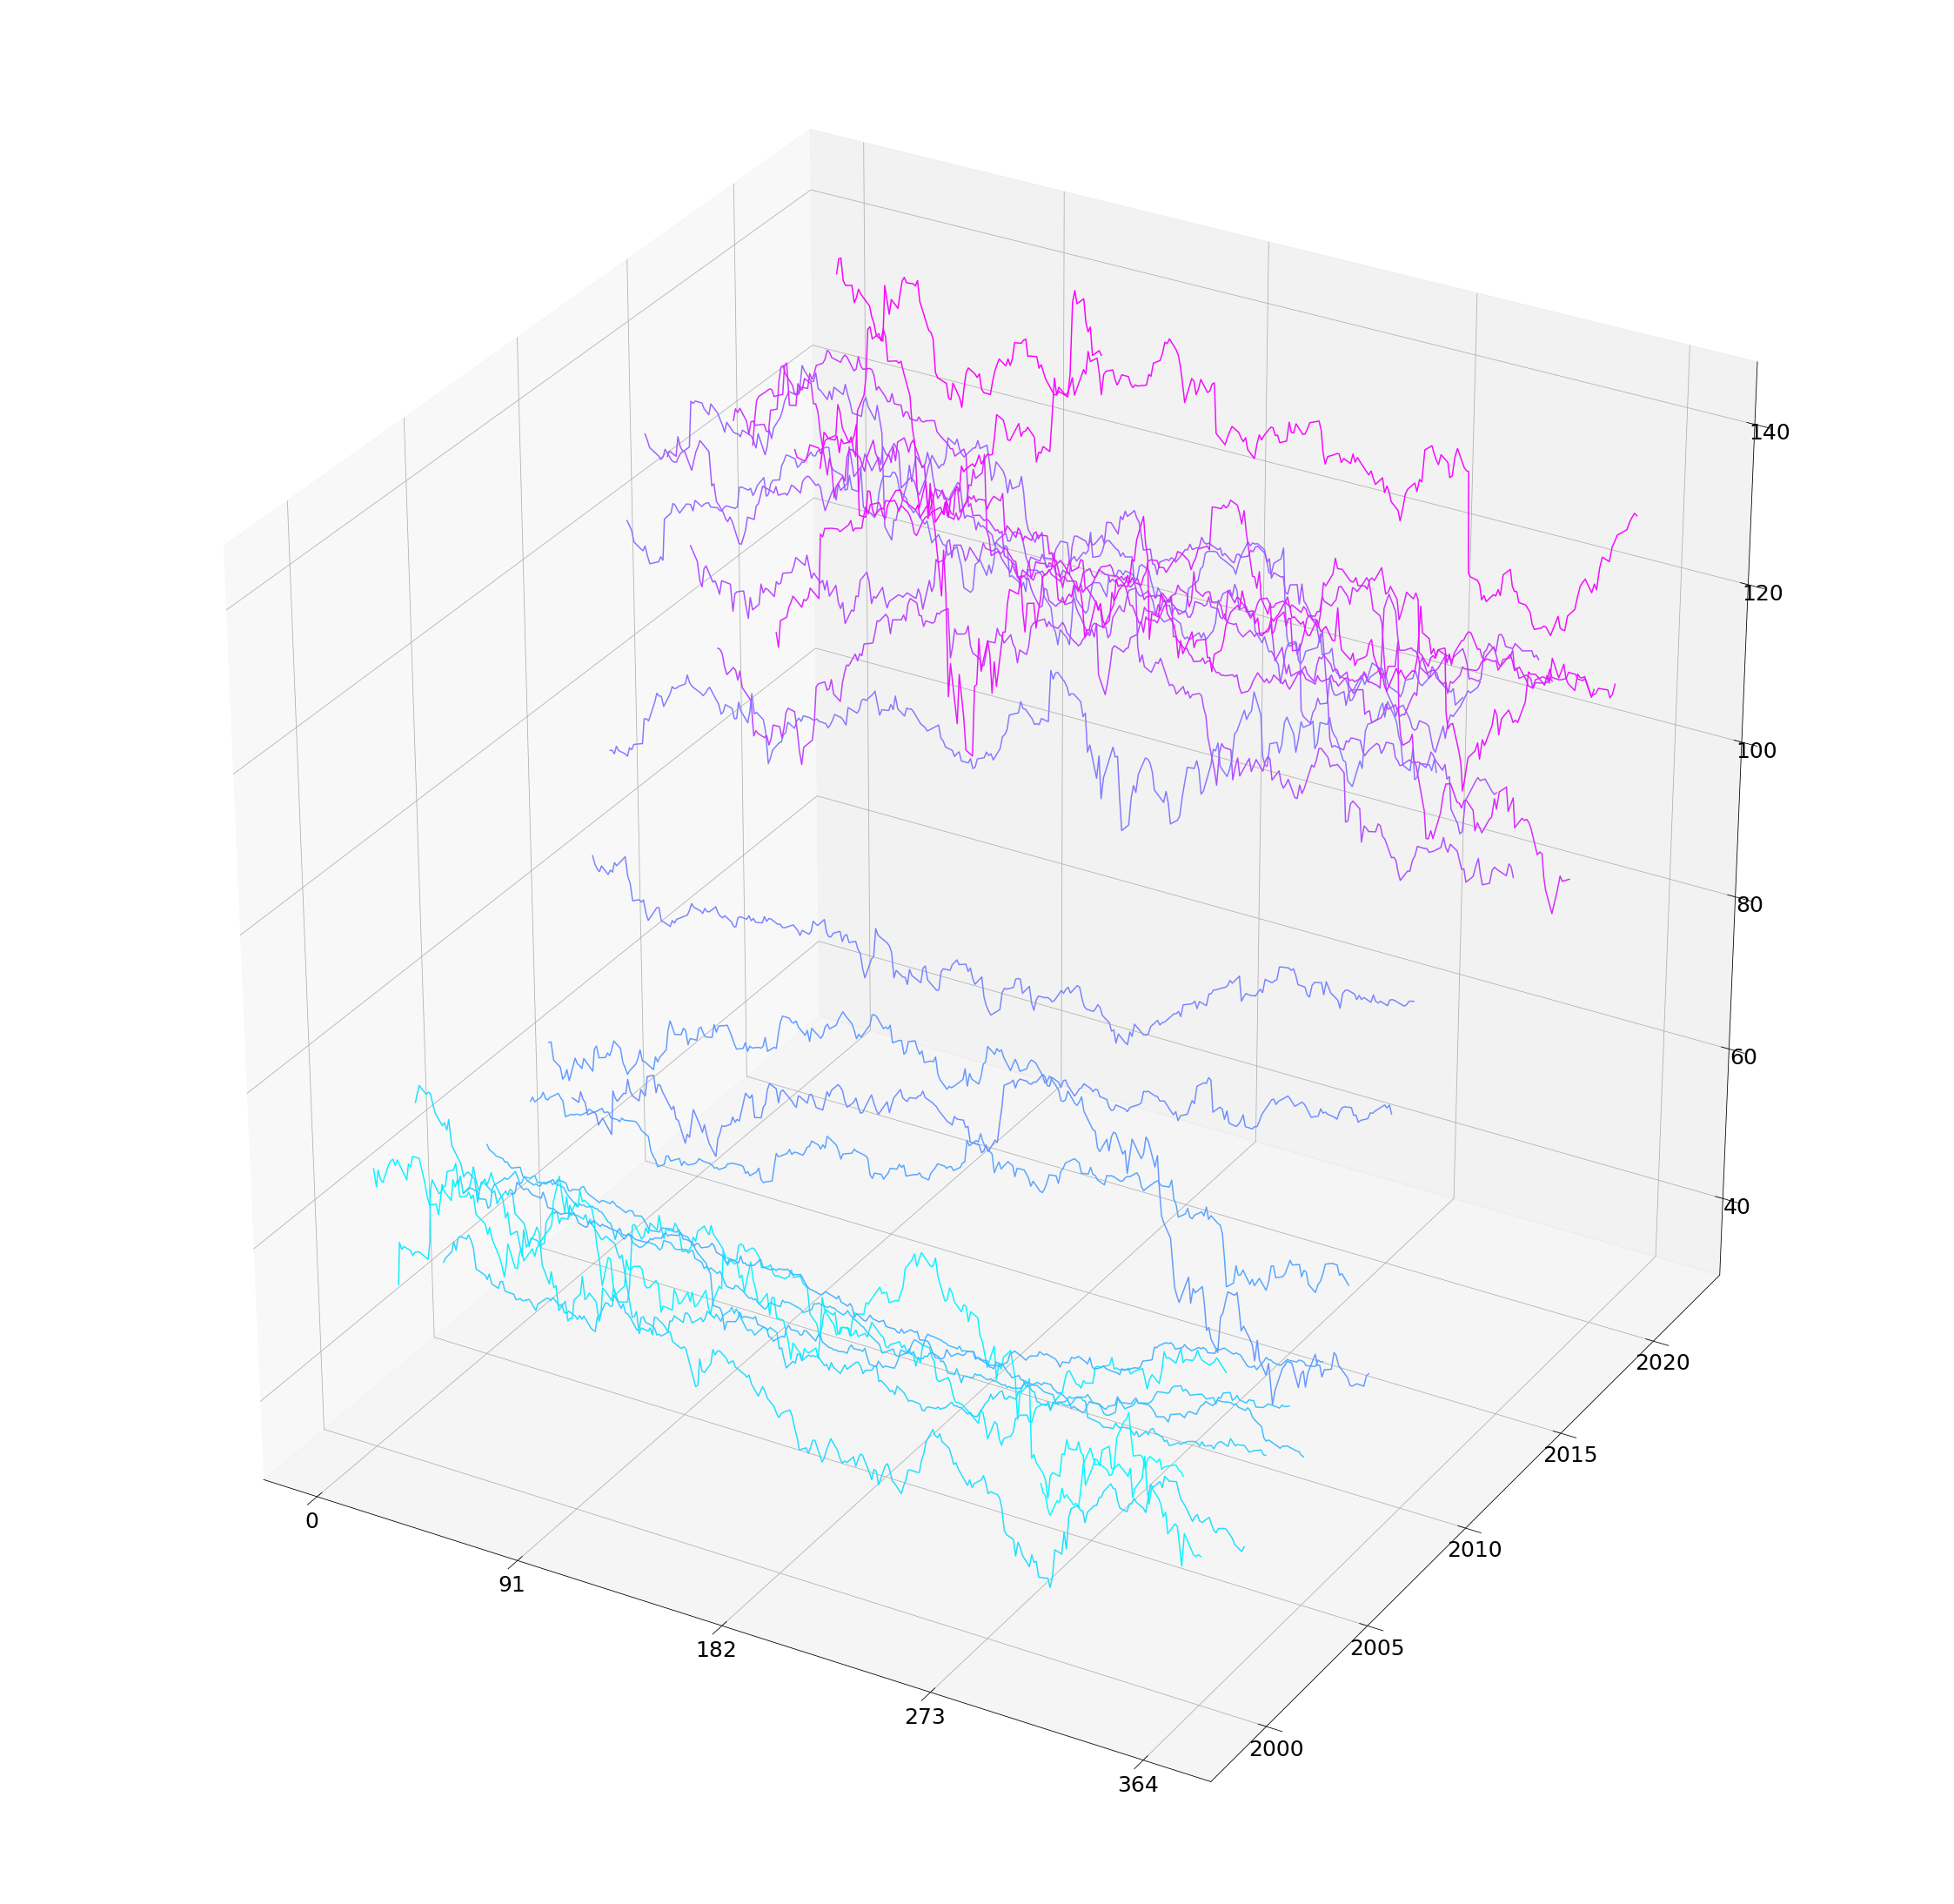

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits import mplot3d

fig, ax = plt.subplots(1, 1, figsize=(40, 40))

plt.title(f'{symbol} by Year', fontsize=40)

# the big difference, 3d axes:
ax = plt.axes(projection='3d')

# create color map
color_map = cm.get_cmap('cool', len(by_years_with_day))
color_map = color_map(np.linspace(0, 1, len(by_years_with_day)))
    # color_map = np.flip(color_map, axis=0) # <-- can flip the color map like this if want to

# make the font bigger
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.zaxis.set_tick_params(labelsize=25)

# set major ticks to every quarter
ax.xaxis.set_major_locator(MultipleLocator(91))
ax.yaxis.set_major_locator(MultipleLocator(5))


for indx, year_rows in enumerate(by_years_with_day):
    year = pd.to_datetime(year_rows[0][1], format='%Y-%m-%d').year
    np_year_rows = np.array(year_rows)[:,[0,6]].T
    z = np.linspace(year, year, len(np_year_rows[0]))
    ax.plot3D(np_year_rows[0].astype(int), z, np_year_rows[1].astype(float), color=color_map[indx])
    
    
plt.show()